# Data wrangling : sparsify, use indices for labels

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sps

In [2]:
envs = pd.read_csv('training_environments.csv', index_col=0)
empo_names = [f'empo_{i}' for i in range(1, 4)]
empo_index_to_label = []

for empo in empo_names:
    empo_index_to_label.append([str(row) for row in envs.drop_duplicates(subset=empo)[empo]])
    
empo_label_to_index = {name : {label : i for i, label in enumerate(labels)} for name, labels in zip(empo_names, empo_index_to_label)}
empo_label_to_index

{'empo_1': {'Free-living': 0, 'Host-associated': 1},
 'empo_2': {'Non-saline': 0, 'Saline': 1, 'Animal': 2, 'Plant': 3},
 'empo_3': {'Water (non-saline)': 0,
  'Soil (non-saline)': 1,
  'Sediment (saline)': 2,
  'Animal surface': 3,
  'Surface (non-saline)': 4,
  'Animal distal gut': 5,
  'Animal corpus': 6,
  'Plant surface': 7,
  'Water (saline)': 8,
  'Animal secretion': 9,
  'Sediment (non-saline)': 10,
  'Plant rhizosphere': 11,
  'Plant corpus': 12,
  'Surface (saline)': 13,
  'Animal proximal gut': 14,
  'Aerosol (non-saline)': 15,
  'Hypersaline (saline)': 16}}

In [3]:
# replace text labels with integers
envs = envs.replace(empo_label_to_index)

In [4]:
import numpy as np

In [5]:
def save_as_sparse(in_filename, out_filename):
    line_count = sum(1 for line in open(in_filename))
    rows = []
    with open(in_filename) as f:
        for i, line in enumerate(f):
            if i == 0:
                continue
            row = [int(x) for x in line.strip().split(',')[1:]]
            row = sps.csr_matrix(row)
            rows.append(row)

            if i % 1000 == 0:
                print(f'Sparsifying {in_filename} [row {i} / {line_count}]\r')
    mat = sps.vstack(rows)
    
    sps.save_npz(out_filename, mat)

In [6]:
from pathlib import Path

def maybe_sparsify(in_filename, out_filename):
    if not Path(out_filename).is_file():
        save_as_sparse(in_filename, out_filename)
    
maybe_sparsify('training_descriptors.csv', 'training_descriptors_sparse.npz')
maybe_sparsify('challenge_descriptors.csv', 'challenge_descriptors_sparse.npz')

In [7]:
desc = sps.load_npz('training_descriptors_sparse.npz')

In [8]:
def sparse_megabytes(arr):
    return (arr.data.nbytes + arr.indptr.nbytes + arr.indices.nbytes) / (1024 * 1024)

print(f'In-memory size of desc : {sparse_megabytes(desc):.2f}M')

In-memory size of desc : 496.68M


# Classification

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate

clf_logit = LogisticRegression(random_state=0, n_jobs=-1)
clf_rforest = RandomForestClassifier(random_state=0, n_jobs=-1)

In [19]:
def cross_validate_clf(clf, desc, envs, empo, samples=None, fast=False, n_splits=5):
    samples = samples if samples is not None else desc.shape[0]
    
    # shuffle and truncate data
    idx = np.arange(samples)

    gen = np.random.default_rng(0)
    gen.shuffle(idx)
    idx = idx[:samples]
    
    desc = desc[idx]
    envs = envs.iloc[idx]
    
    if fast:
        print('Warning : using fast evaluation, cross-validation turned off.')
        
        train_pcent = 1 - 1 / n_splits
        train_count = int(round(train_pcent * samples))

        desc_train = desc_shuf[:train_count]
        desc_validate = desc_shuf[train_count:]

        envs_train = envs_shuf[:train_count]
        envs_validate = envs_shuf[train_count:]

        clf.fit(desc_train, envs_train[empo])
        accuracy = clf.score(desc_validate, envs_validate[empo])
        accuracies = np.array([accuracy])
        
        f1 = f1_score(clf.predict(desc_validate), envs_validate[empo], average='weighted')
        f1 = np.array([f1])
    else:
        # cross validation
        k_folds = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    
        scores = cross_validate(clf, desc, envs[empo], cv=k_folds, scoring=['accuracy', 'f1_weighted'], n_jobs=2)
        accuracies = scores['test_accuracy']
        f1 = scores['test_f1_weighted']
    return accuracies, f1

In [16]:
print('Logistic regression scores :')

scores = {}

for empo in empo_names:
    scores[empo] = {}
    accuracies, f1 = cross_validate_clf(clf_logit, desc, envs, empo)
    scores[empo]['f1'] = f1
    scores[empo]['accuracies'] = accuracies
    
    print(scores[empo])
    
print(scores)

Logistic regression scores :
{'f1': array([0.96450476, 0.95949694, 0.96402493, 0.9594926 , 0.96234805]), 'accuracies': array([0.96449845, 0.95949488, 0.96402192, 0.95948522, 0.96234509])}
{'f1': array([0.96069563, 0.95762676, 0.95663415, 0.95593066, 0.95425537]), 'accuracies': array([0.9606862 , 0.95758875, 0.95663569, 0.95591039, 0.95424214])}
{'f1': array([0.93741607, 0.92809562, 0.93434409, 0.93493431, 0.92558075]), 'accuracies': array([0.93757446, 0.92828211, 0.93447701, 0.93541468, 0.92588179])}
{'empo_1': {'f1': array([0.96450476, 0.95949694, 0.96402493, 0.9594926 , 0.96234805]), 'accuracies': array([0.96449845, 0.95949488, 0.96402192, 0.95948522, 0.96234509])}, 'empo_2': {'f1': array([0.96069563, 0.95762676, 0.95663415, 0.95593066, 0.95425537]), 'accuracies': array([0.9606862 , 0.95758875, 0.95663569, 0.95591039, 0.95424214])}, 'empo_3': {'f1': array([0.93741607, 0.92809562, 0.93434409, 0.93493431, 0.92558075]), 'accuracies': array([0.93757446, 0.92828211, 0.93447701, 0.93541468

,taxonomy_0,taxonomy_1,taxonomy_2,taxonomy_3,taxonomy_4,taxonomy_5,taxonomy_6
JN643047.1.1268,D_0__Bacteria,D_1__Planctomycetes,D_2__Phycisphaerae,D_3__Phycisphaerales,D_4__Phycisphaeraceae,D_5__AKYG587,D_6__uncultured bacterium
LC012891.1.1471,D_0__Bacteria,D_1__Firmicutes,D_2__Bacilli,D_3__Lactobacillales,D_4__Streptococcaceae,D_5__Streptococcus,D_6__Streptococcus sp. TKU49
JX843283.1.1452,D_0__Bacteria,D_1__Proteobacteria,D_2__Alphaproteobacteria,D_3__Rhodospirillales,D_4__Rhodospirillaceae,D_5__Azospirillum,D_6__Niveispirillum fermenti
LN614633.1.1389,D_0__Bacteria,D_1__Actinobacteria,D_2__Actinobacteria,D_3__Corynebacteriales,D_4__Mycobacteriaceae,D_5__Mycobacterium,D_6__Mycobacterium sp. L1E08A
HW066356.1.1487,D_0__Bacteria,D_1__Bacteroidetes,D_2__Bacteroidia,D_3__Bacteroidales,D_4__Porphyromonadaceae,D_5__Odoribacter,D_6__unidentified
AM162429.1.1516,D_0__Bacteria,D_1__Acidobacteria,D_2__Acidobacteria,D_3__Subgroup 2,D_4__uncultured bacterium,D_5__uncultured bacterium,D_6__uncultured bacterium
KF927709.1.1519,D_0__Bacteria,D_1__Actinobacteria,D_2__Acidimicrobiia,D_3__Acidimicrobiales,D_4__uncultured,D_5__uncultured bacterium,D_6__uncultured bacterium
JX079114.1.1480,D_0__Bacteria,D_1__Actinobacteria,D_2__Actinobacteria,D_3__Propionibacteriales,D_4__Nocardioidaceae,D_5__Marmoricola,D_6__uncultured Nocardioides sp.
KF911196.1.1459,D_0__Bacteria,D_1__Proteobacteria,D_2__Gammaproteobacteria,D_3__Pseudomonadales,D_4__Pseudomonadaceae,D_5__Pseudomonas,D_6__uncultured bacterium
EU462062.1.1390,D_0__Bacteria,D_1__Firmicutes,D_2__Clostridia,D_3__Clostridiales,D_4__Lachnospiraceae,D_5__uncultured,D_6__uncultured bacterium


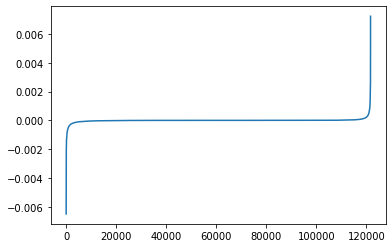

In [21]:
n_features = desc.shape[-1]

# D_0 : Domain
# D_1 : ?
# D_2 : Class
# D_3 : Order
# D_4 : Family
# D_5 : ?
# D_6 : ?

clf_logit.fit(desc, envs['empo_1'])
feature_idx = np.argsort(clf_logit.coef_[0])
plt.plot(range(n_features), sorted(clf_logit.coef_[0][feature_idx]))

species = pd.read_csv('bacterial_species.csv', index_col=0)
species.iloc[feature_idx][-60:]

# Dimensionality reduction

In [19]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200)
svd.fit(desc)

TruncatedSVD(n_components=200)

In [20]:
svd.explained_variance_ratio_.sum()

0.8926820709635899

In [21]:
desc_reduced = svd.transform(desc)

In [22]:
eval_clf(clf_logit, desc_reduced, envs, 'empo_1')

array([0.91875149, 0.92208721, 0.91231832, 0.9163489 , 0.91801716])

In [23]:
eval_clf(clf_logit, desc_reduced, envs, 'empo_2')

array([0.91827496, 0.9166071 , 0.91208006, 0.91515729, 0.91015253])

In [24]:
eval_clf(clf_logit, desc_reduced, envs, 'empo_3')

array([0.8656183 , 0.85227543, 0.85966166, 0.86439466, 0.85772164])

In [25]:
svd.components_.shape

(200, 121694)

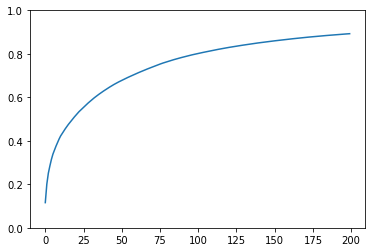

In [26]:
plt.ylim(0, 1)
plt.plot(svd.explained_variance_ratio_.cumsum())

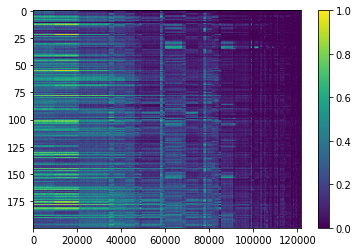

In [27]:
plt.imshow(svd.components_ > 1e-6, aspect='auto')
plt.colorbar()

In [28]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=200)

In [29]:
n=100
selector.fit(desc[:n], envs['empo_1'][:n])

SelectKBest(k=200, score_func=<function mutual_info_classif at 0x7f594bdb3160>)